<a href="https://colab.research.google.com/github/rahulprasanth487/S3-STORAGE-GCS-migration/blob/main/Final_Scripts_for_migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-auth google-auth-oauthlib google-cloud-storage

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.cloud import storage
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
import os

In [ ]:
import boto3
from google.oauth2.credentials import Credentials
from google.cloud import storage
import tempfile

In [ ]:
def migrate_s3_to_gcs(s3_bucket_name, gcs_bucket_name, access_token,
                      s3_prefix='', gcs_base_prefix='', project_id='qwiklabs-gcp-00-1795097857bb'):

    # Initialize S3 client
    s3 = boto3.client(
        's3',
        aws_access_key_id='xxxx',
        aws_secret_access_key='xxxx',
        region_name='us-east-1'
    )

    # Initialize GCS client
    credentials = Credentials(token=access_token)
    gcs_client = storage.Client(credentials=credentials, project=project_id)
    gcs_bucket = gcs_client.bucket(gcs_bucket_name)

    # List objects in S3 bucket
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=s3_bucket_name, Prefix=s3_prefix)

    # Track directories we've seen to create them in GCS
    processed_dirs = set()

    # Process each object
    for page in pages:
        if 'Contents' not in page:
            print(f"No objects found in S3 bucket '{s3_bucket_name}' with prefix '{s3_prefix}'")
            continue

        for obj in page['Contents']:
            s3_key = obj['Key']

            # Skip folder placeholder objects (objects that end with '/')
            if s3_key.endswith('/'):
                print(f"Skipping directory placeholder: {s3_key}")
                continue

            print(f"Processing file: {s3_key}")

            # Create a temp file to store the S3 object content
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                temp_file_path = temp_file.name

            try:
                # Download from S3 to temp file
                s3.download_file(s3_bucket_name, s3_key, temp_file_path)

                # Preserve directory structure in GCS
                if gcs_base_prefix:
                    gcs_destination = f"{gcs_base_prefix.rstrip('/')}/{s3_key}"
                else:
                    gcs_destination = s3_key

                # Create "directory" structure in GCS (not strictly necessary as GCS uses flat namespace,
                # but helps with organization and improves console browsing experience)
                dir_path = os.path.dirname(gcs_destination)
                if dir_path and dir_path not in processed_dirs:
                    # Create an empty directory marker object if needed
                    if dir_path:
                        dir_blob = gcs_bucket.blob(f"{dir_path}/")
                        dir_blob.upload_from_string('')
                        processed_dirs.add(dir_path)

                # Upload to GCS
                blob = gcs_bucket.blob(gcs_destination)
                blob.upload_from_filename(temp_file_path)

                print(f"Migrated '{s3_key}' to '{gcs_destination}' in GCS bucket '{gcs_bucket_name}'")

            finally:
                # Clean up temp file
                if os.path.exists(temp_file_path):
                    os.remove(temp_file_path)


In [ ]:
def list_s3_directories(s3_bucket_name, prefix=''):

    s3 = boto3.client(
        's3',
        aws_access_key_id='xxxx',
        aws_secret_access_key='xxxx',
        region_name='us-east-1'
    )

    # Use the list_objects_v2 with delimiter to get directories
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=s3_bucket_name, Prefix=prefix, Delimiter='/')

    directories = []

    for page in pages:
        # Add common prefixes (directories)
        if 'CommonPrefixes' in page:
            for common_prefix in page['CommonPrefixes']:
                directories.append(common_prefix['Prefix'])

    return directories


In [ ]:
list_s3_directories('tachyon1')

['Sample _directory/', 'tachyon-explore-audio/', 'tachyon-explore-images/']

In [ ]:
def migrate_s3_directories_to_gcs(s3_bucket_name, gcs_bucket_name, access_token, project_id='qwiklabs-gcp-02-f8173b20b53b'):

    # First, list top-level directories
    top_dirs = list_s3_directories(s3_bucket_name)

    # If no directories, migrate the root
    if not top_dirs:
        print("No directories found. Migrating files from root...")
        migrate_s3_to_gcs(s3_bucket_name, gcs_bucket_name, access_token,
                         s3_prefix='', gcs_base_prefix='', project_id=project_id)
        return

    for directory in top_dirs:
        if directory.startswith("tachyon-explore"):
            print(f"Processing directory: {directory}")

            # Migrate this directory
            migrate_s3_to_gcs(
                s3_bucket_name=s3_bucket_name,
                gcs_bucket_name=gcs_bucket_name,
                access_token=access_token,
                s3_prefix=directory,
                gcs_base_prefix='',  # Keep the original structure
                project_id=project_id
            )

            # Recursively look for subdirectories and migrate them
            subdirs = list_s3_directories(s3_bucket_name, directory)
            for subdir in subdirs:
                print(f"Processing subdirectory: {subdir}")
                migrate_s3_to_gcs(
                    s3_bucket_name=s3_bucket_name,
                    gcs_bucket_name=gcs_bucket_name,
                    access_token=access_token,
                    s3_prefix=subdir,
                    gcs_base_prefix='',  # Keep the original structure
                    project_id=project_id
                )
        else:
            print(f"Skipping directory: {directory} (does not match 'tachyon-explore-' prefix)")

In [ ]:
if __name__ == "__main__":
    # S3 configuration
    s3_bucket_name = "tachyon1"

    # GCS configuration
    gcs_bucket_name = "hpos_migraton"
    access_token = "xxxx"
    project_id = "qwiklabs-gcp-02-f8173b20b53b"

    # Option 1: Run migration on entire bucket, preserving directory structure
    migrate_s3_directories_to_gcs(s3_bucket_name, gcs_bucket_name, access_token, project_id)


Skipping directory: Sample _directory/ (does not match 'tachyon_explore_' prefix)
Processing directory: tachyon-explore-audio/
Skipping directory placeholder: tachyon-explore-audio/
Processing file: tachyon-explore-audio/into_your_arms.mp3
Migrated 'tachyon-explore-audio/into_your_arms.mp3' to 'tachyon-explore-audio/into_your_arms.mp3' in GCS bucket 'hpos_migraton'
Processing file: tachyon-explore-audio/lauging audio.m4a
Migrated 'tachyon-explore-audio/lauging audio.m4a' to 'tachyon-explore-audio/lauging audio.m4a' in GCS bucket 'hpos_migraton'
Processing directory: tachyon-explore-images/
Skipping directory placeholder: tachyon-explore-images/
Processing file: tachyon-explore-images/GT logo.jpg
Migrated 'tachyon-explore-images/GT logo.jpg' to 'tachyon-explore-images/GT logo.jpg' in GCS bucket 'hpos_migraton'
Processing file: tachyon-explore-images/Green and Black Modern Gamer YouTube Banner.png
Migrated 'tachyon-explore-images/Green and Black Modern Gamer YouTube Banner.png' to 'tachy

OUTPUTS:
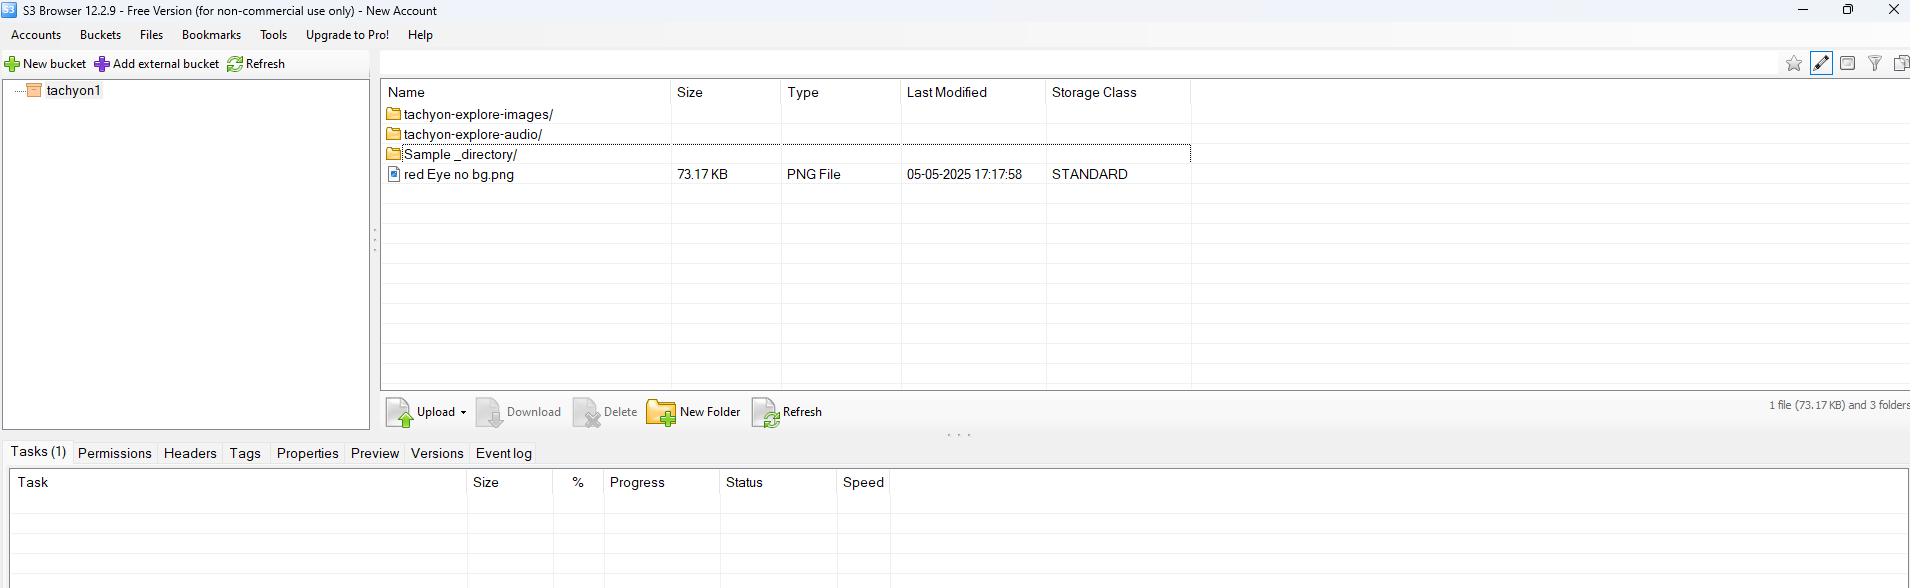

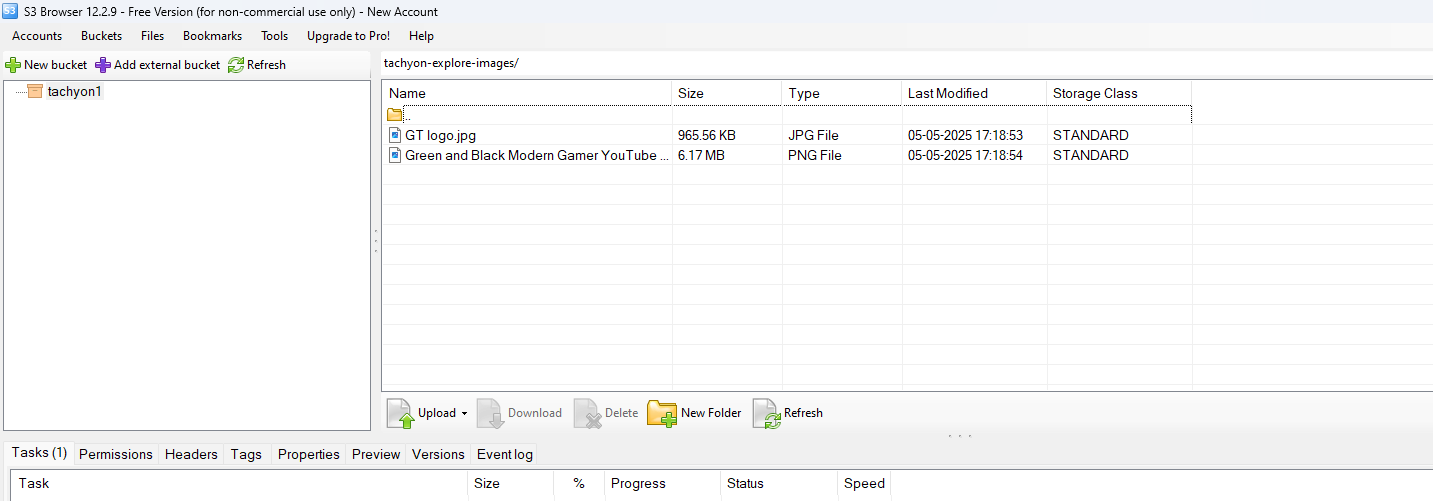

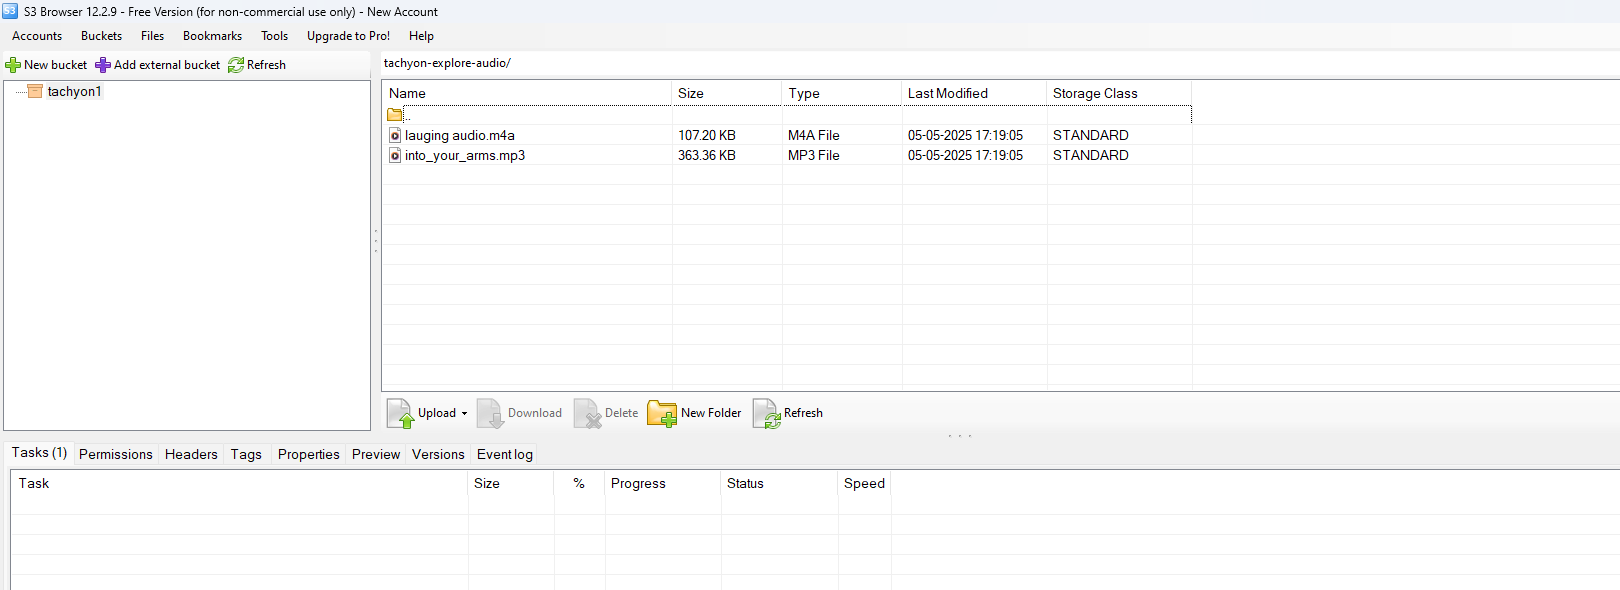

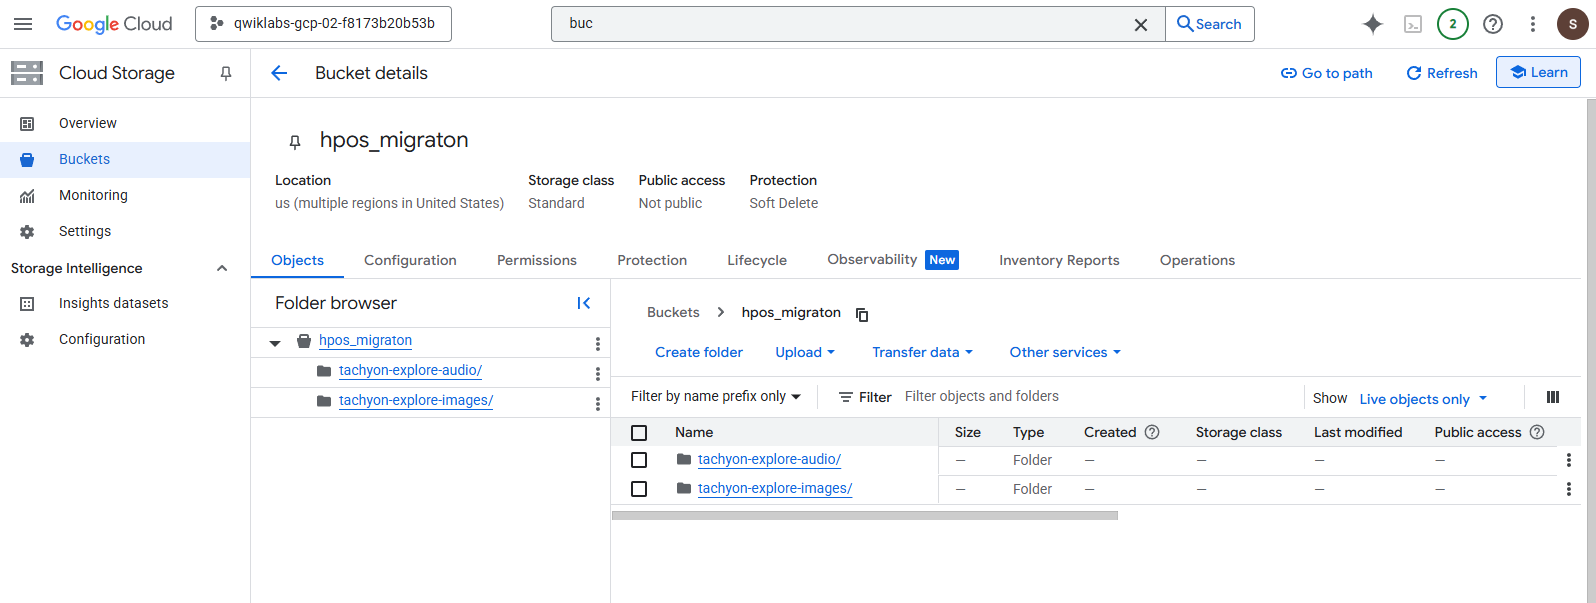

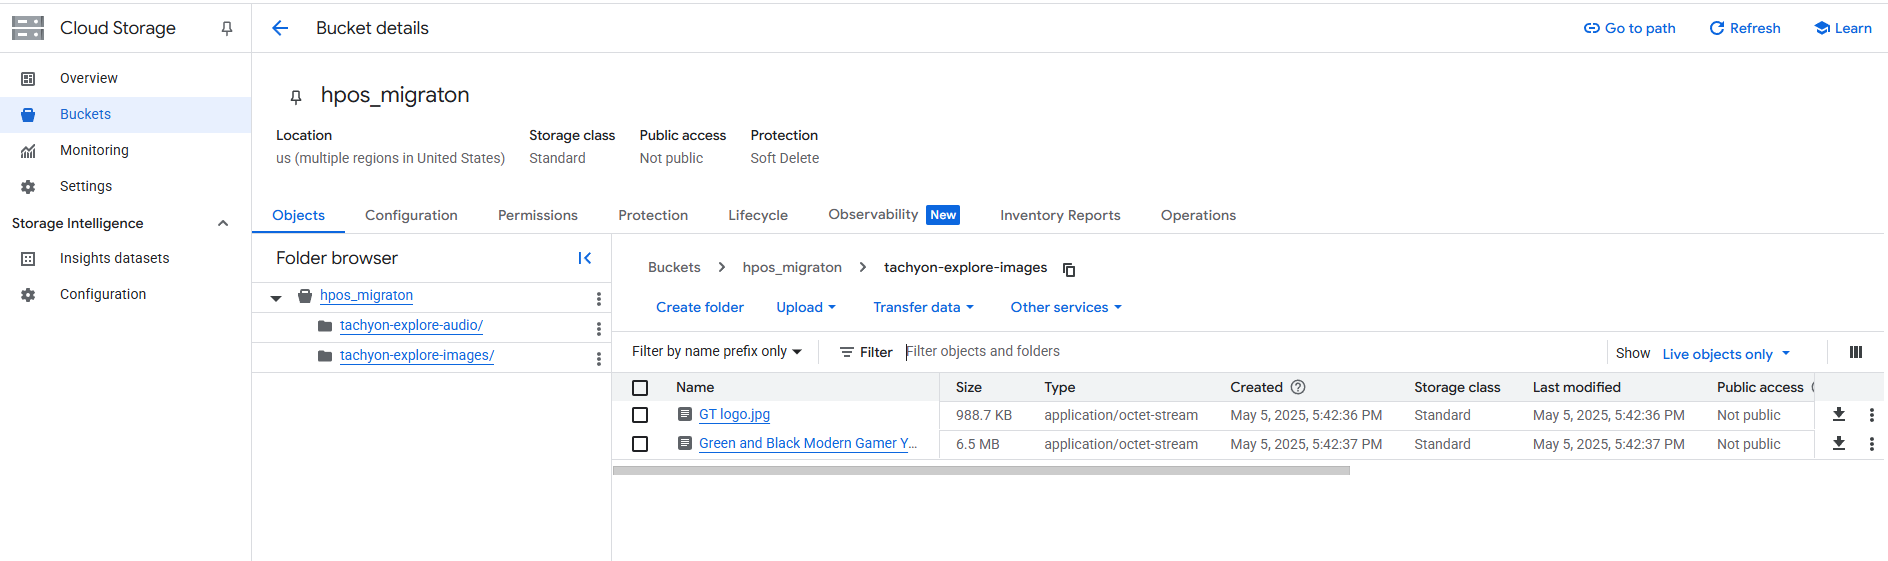

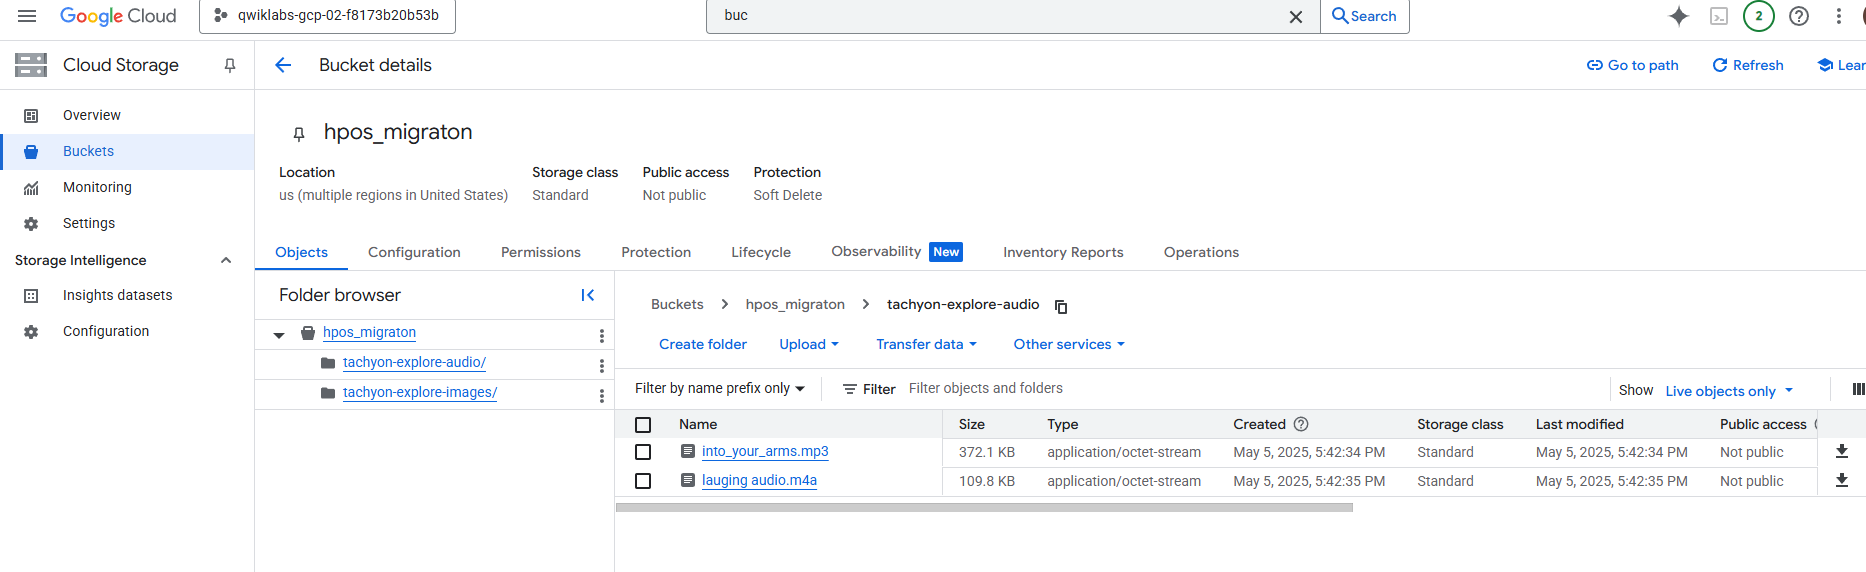